In [1]:
!pip install pyspark

     |████████████████████████████████| 204.7MB 184kB/s  eta 0:00:01
     |████████████████████████████████| 204kB 49.7MB/s eta 0:00:01
  Stored in directory: /home/dsxuser/.cache/pip/wheels/57/27/4d/ddacf7143f8d5b76c45c61ee2e43d9f8492fc5a8e78ebd7d37
Successfully built pyspark


In [2]:
from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession

In [3]:
sc = SparkContext.getOrCreate(SparkConf().setMaster("local[*]"))
spark = SparkSession \
    .builder \
    .getOrCreate()

In [4]:
from IPython.display import Markdown, display
def printmd(string):
    display(Markdown('# <span style="color:green">'+string+'</span>'))

In [36]:
!wget https://github.com/IBM/coursera/blob/master/coursera_ds/washing.parquet?raw=true
!mv washing.parquet?raw=true washing.parquet

--2020-06-25 17:55:05--  https://github.com/IBM/coursera/blob/master/coursera_ds/washing.parquet?raw=true
Resolving github.com (github.com)... 140.82.114.3
Connecting to github.com (github.com)|140.82.114.3|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://github.com/IBM/skillsnetwork/blob/master/coursera_ds/washing.parquet?raw=true [following]
--2020-06-25 17:55:05--  https://github.com/IBM/skillsnetwork/blob/master/coursera_ds/washing.parquet?raw=true
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/IBM/skillsnetwork/raw/master/coursera_ds/washing.parquet [following]
--2020-06-25 17:55:05--  https://github.com/IBM/skillsnetwork/raw/master/coursera_ds/washing.parquet
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/IBM/skillsnetwork/master/coursera_ds/washing.parquet [fo

In [37]:
df = spark.read.parquet('washing.parquet')
df.createOrReplaceTempView('washing')
df.show()

+--------------------+--------------------+-----+--------+----------+---------+--------+-----+-----------+-------------+-------+
|                 _id|                _rev|count|flowrate|fluidlevel|frequency|hardness|speed|temperature|           ts|voltage|
+--------------------+--------------------+-----+--------+----------+---------+--------+-----+-----------+-------------+-------+
|0d86485d0f88d1f9d...|1-57940679fb8a713...|    4|      11|acceptable|     null|      77| null|        100|1547808723923|   null|
|0d86485d0f88d1f9d...|1-15ff3a0b304d789...|    2|    null|      null|     null|    null| 1046|       null|1547808729917|   null|
|0d86485d0f88d1f9d...|1-97c2742b68c7b07...|    4|    null|      null|       71|    null| null|       null|1547808731918|    236|
|0d86485d0f88d1f9d...|1-eefb903dbe45746...|   19|      11|acceptable|     null|      75| null|         86|1547808738999|   null|
|0d86485d0f88d1f9d...|1-5f68b4c72813c25...|    7|    null|      null|       75|    null| null|   

In [9]:
printmd('<<<<<!!!!! Box plot !!!!!>>>>>')

# <span style="color:green"><<<<<!!!!! Box plot !!!!!>>>>></span>

In [8]:
results=spark.sql("select voltage from washing where voltage is not null")
results_array=results.rdd.map(lambda row:row.voltage).sample(False, 0.1).collect()

{'whiskers': [<matplotlib.lines.Line2D at 0x7f4b40543a90>,
 'caps': [<matplotlib.lines.Line2D at 0x7f4b4055a160>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f4b40543940>],
 'medians': [<matplotlib.lines.Line2D at 0x7f4b4055a7f0>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f4b4055ab38>],
 'means': []}

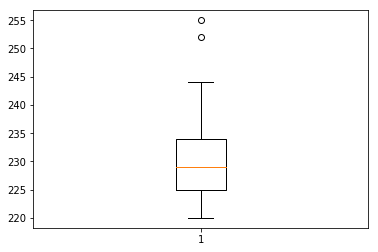

In [9]:
import matplotlib.pyplot as plt
plt.boxplot(results_array)

In [10]:
printmd('<<<<<!!!!! time series !!!!!>>>>>')

# <span style="color:green"><<<<<!!!!! time series !!!!!>>>>></span>

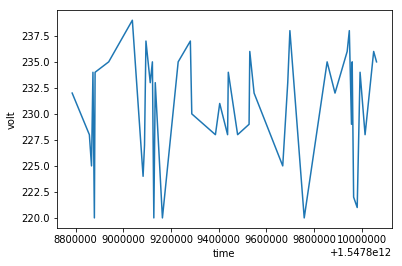

In [38]:
results=spark.sql("select voltage, ts from washing where voltage is not null order by ts asc")
results_sample=results.rdd.sample(False, 0.1)
results_volt=results_sample.map(lambda row:row.voltage).collect()
results_ts=results_sample.map(lambda row:row.ts).collect()
import matplotlib.pyplot as plt
plt.plot(results_ts, results_volt)
plt.xlabel('time')
plt.ylabel('volt')
plt.show()

In [12]:
printmd('<<<<<!!!!! 3d scatter plot !!!!!>>>>>')

# <span style="color:green"><<<<<!!!!! 3d scatter plot !!!!!>>>>></span>

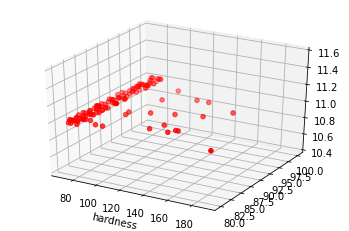

In [15]:
results=spark.sql("select hardness, temperature, flowrate from washing where hardness is not null and flowrate is not null and temperature is not null")
results_sample=results.rdd.sample(False, 0.1)
results_hardness=results_sample.map(lambda x:x.hardness).collect()
results_temperature=results_sample.map(lambda x:x.temperature).collect()
results_flowrate=results_sample.map(lambda x:x.flowrate).collect()

from mpl_toolkits.mplot3d import Axes3D
fig=plt.figure()
ax=fig.add_subplot(111, projection='3d')
ax.scatter(results_hardness, results_temperature, results_flowrate, c='r', marker='o')
ax.set_xlabel('hardness')
plt.show()

In [8]:
printmd('<<<<<!!!!! PCA !!!!!>>>>>')

# <span style="color:green"><<<<<!!!!! PCA !!!!!>>>>></span>

In [17]:
results=spark.sql("""SELECT * from (\
					 SELECT \
					 min(temperature) over w as min_temp, \
					 max(temperature) over w as max_temp, \
					 min(voltage) over w as min_volt,\
					 min(voltage) over w as max_volt, \
					 min(flowrate) over w as min_flowrate, \
					 max(flowrate) over w as max_flowrate, \
					 min(frequency) over w as min_freq, \
					 max(frequency) over w as max_freq, \
					 min(hardness) over w as min_hardness,\
					 max(hardness) over w as max_hardness, \
					 min(speed) over w as min_speed, \
					 max(speed) over w as max_speed \
					 FROM washing \
					 WINDOW w AS(ORDER BY ts ROWS BETWEEN CURRENT ROW AND 10 FOLLOWING)\
                 )\
                 where min_temp is not null \
                 and max_temp is not null \
                 and min_volt is not null \
                 and max_volt is not null \
                 and min_flowrate is not null \
                 and max_flowrate is not null \
                 and min_freq is not null \
                 and max_freq is not null \
                 and min_hardness is not null\
                 and max_hardness is not null \
                 and min_speed is not null \
                 and max_speed is not null \
                 """)
results.take(5)

[Row(min_temp=81, max_temp=100, min_volt=221, max_volt=221, min_flowrate=11, max_flowrate=11, min_freq=68, max_freq=76, min_hardness=71, max_hardness=78, min_speed=1033, max_speed=1033),
 Row(min_temp=81, max_temp=100, min_volt=221, max_volt=221, min_flowrate=11, max_flowrate=11, min_freq=68, max_freq=76, min_hardness=72, max_hardness=78, min_speed=1033, max_speed=1033),
 Row(min_temp=81, max_temp=100, min_volt=221, max_volt=221, min_flowrate=11, max_flowrate=11, min_freq=68, max_freq=76, min_hardness=72, max_hardness=80, min_speed=1033, max_speed=1033),
 Row(min_temp=81, max_temp=100, min_volt=222, max_volt=222, min_flowrate=11, max_flowrate=11, min_freq=68, max_freq=74, min_hardness=72, max_hardness=80, min_speed=1033, max_speed=1046),
 Row(min_temp=81, max_temp=100, min_volt=222, max_volt=222, min_flowrate=11, max_flowrate=11, min_freq=68, max_freq=74, min_hardness=73, max_hardness=80, min_speed=1033, max_speed=1046)]

In [18]:
results.count()

2051

In [19]:
from pyspark.ml.feature import PCA
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler

In [22]:
assembler =VectorAssembler(inputCols=results.columns, outputCol='features')
features=assembler.transform(results)
features.rdd.map(lambda x:x.features).take(5)

[DenseVector([81.0, 100.0, 221.0, 221.0, 11.0, 11.0, 68.0, 76.0, 71.0, 78.0, 1033.0, 1033.0]),
 DenseVector([81.0, 100.0, 221.0, 221.0, 11.0, 11.0, 68.0, 76.0, 72.0, 78.0, 1033.0, 1033.0]),
 DenseVector([81.0, 100.0, 221.0, 221.0, 11.0, 11.0, 68.0, 76.0, 72.0, 80.0, 1033.0, 1033.0]),
 DenseVector([81.0, 100.0, 222.0, 222.0, 11.0, 11.0, 68.0, 74.0, 72.0, 80.0, 1033.0, 1046.0]),
 DenseVector([81.0, 100.0, 222.0, 222.0, 11.0, 11.0, 68.0, 74.0, 73.0, 80.0, 1033.0, 1046.0])]

In [24]:
pca=PCA(k=3, inputCol='features', outputCol="pcafeatures")
model=pca.fit(features)

In [26]:
result_pca=model.transform(features).select("pcafeatures")
result_pca.show(truncate=False)

+-----------------------------------------------------------+
|pcafeatures                                                |
+-----------------------------------------------------------+
|[1460.2673589937813,-16.185854724590747,65.50987419468618] |
|[1460.2838746165446,-16.554036858452143,65.45288538566206] |
|[1460.377991952531,-18.409689020421943,65.48067325332761]  |
|[1469.9825798984805,-17.819467283811093,56.726925439764045]|
|[1469.9990955212438,-18.187649417672503,56.669936630739926]|
|[1469.996020597539,-18.20700080005993,56.60928130487025]   |
|[1478.7194577956705,-17.84513084798077,66.22022608838643]  |
|[1478.7194577956705,-17.84513084798077,66.22022608838643]  |
|[1478.7350334433954,-17.81112128437735,66.17807879758993]  |
|[1478.7350334433954,-17.81112128437735,66.17807879758993]  |
|[1483.907621337256,-17.555345305349817,61.37045720857441]  |
|[1483.883541874458,-18.416411306285156,61.4110196567799]   |
|[1483.726479876179,-17.16619774597163,61.357500549256656]  |
|[1483.7

In [27]:
result_pca.count()

2051

In [29]:
result_rdd=result_pca.rdd.sample(False, 0.1)

In [32]:
x=result_rdd.map(lambda x: x.pcafeatures[0]).collect()
y=result_rdd.map(lambda x: x.pcafeatures[1]).collect()
z=result_rdd.map(lambda x: x.pcafeatures[2]).collect()

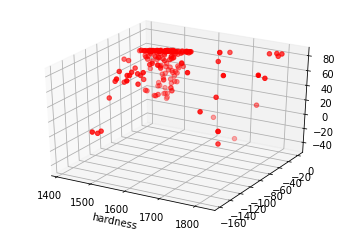

In [35]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
fig=plt.figure()
ax=fig.add_subplot(111, projection='3d')
ax.scatter(x, y, z, c='r', marker='o')
ax.set_xlabel('hardness')
plt.show()